<a href="https://colab.research.google.com/github/ekolmagorov/FailureForecasting/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22STUnet_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import torch 


from torchvision.models import resnet as resnet_modules
from torch.optim import Adam
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import OrderedDict
from torch.utils.tensorboard import SummaryWriter
from google.colab import drive

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon May 24 23:01:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
random.seed(123)

DEVICE  = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

4/1AY0e-g5NK5WsDAYsKgpSmzdSWB2ZEAyHPG5Vwo9U7oLE0-Wrg19cnzv13zc4/1AY0e-g5NK5WsDAYsKgpSmzdSWB2ZEAyHPG5Vwo9U7oLE0-Wrg19cnzv13zc

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
% cd /content/drive/MyDrive/курсовая
#! ls

/content/drive/MyDrive/курсовая


In [6]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [7]:
resnet = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
length = len(list(resnet.children()))
od = OrderedDict()
for index, (name, val) in enumerate(resnet.named_children()):
    if index == length - 2:
        break
    if isinstance(val, nn.BatchNorm2d):
        val = Identity()

    if isinstance(val, nn.Sequential):
        for ch_name, ch_val in val.named_children():
            if isinstance(ch_val, resnet_modules.BasicBlock):
                ch_val.bn1 = Identity()
                ch_val.bn2 = Identity()
                if hasattr(ch_val, 'downsample'):
                    downsample = getattr(ch_val, 'downsample')
                    if isinstance(downsample, nn.Sequential):
                        downsample[1]= Identity()
    
    od[name] = val
#od['maxpool_last'] = nn.Maxpoo

simple_resnet = nn.Sequential(od)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [8]:
print(simple_resnet)

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): Identity()
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): Identity()
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): Identity()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): Identity()
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): Identity()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (b

In [9]:
#vgg = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True).features

In [10]:
#vgg

In [11]:
example_tensor = torch.randn((1, 3, 256, 256))
out = simple_resnet(example_tensor)
out.shape

torch.Size([1, 512, 8, 8])

In [12]:
#hasattr(vgg, '6')
#getattr(vgg, '6')

In [13]:
class EncoderBlock(nn.Module):

    '''
    Encoder part in Unet-style neural network model
    '''

    def __get_activation(self, name):
        def __hook(module, input, output):
            self.output[name] = output

        return __hook


    def __init__(self, encoder_model, output_layers=None, requires_grad=True):
      super(EncoderBlock, self).__init__()

      self.model = encoder_model
      for param in self.model.parameters():
        param.requires_grad = requires_grad
        
      self.output_layers = output_layers
      self.output = {}

      if output_layers is not None:
        
        for idx, layer_name in enumerate(output_layers):

          if not hasattr(self.model, layer_name):
            raise KeyError("such {} in your encoder model doesn't exist".
                           format(layer_name))

          getattr(self.model, layer_name).register_forward_hook(
              self.__get_activation(layer_name)
              )


    def forward(self, x):

      self.output.clear()
      out = self.model(x)
      self.output['out'] = out
      return out, self.output.copy()

In [14]:
LAYERS_NAME = ['relu', 'layer1', 'layer2', 'layer3']
encoder = EncoderBlock(simple_resnet, LAYERS_NAME)

In [15]:
example_tensor = torch.randn((2, 3, 256, 256))
out, d_out = encoder(example_tensor)

In [16]:
for key, value in d_out.items():
    print(key, value.shape)


relu torch.Size([2, 64, 128, 128])
layer1 torch.Size([2, 64, 64, 64])
layer2 torch.Size([2, 128, 32, 32])
layer3 torch.Size([2, 256, 16, 16])
out torch.Size([2, 512, 8, 8])


In [17]:
#print(out, )

In [18]:
#TODO add weights to signal after adain transformation

class AdainBlock(nn.Module):

    def __init__(self, layers_names):
        super(AdainBlock, self).__init__()
        self.layers_names = layers_names
        self.outputs = {}

    def transform(self, content, style):
        content_size, style_size = content.size(), style.size()
        content_sigma = torch.std(content, dim=(2, 3), keepdims=True)#.expand(content_size)
        style_sigma = torch.std(style, dim=(2, 3), keepdims=True)#.expand(style_size)

        content_mu = torch.mean(content, dim=(2, 3), keepdims=True)#.expand(content_size)
        style_mu = torch.mean(style, dim=(2, 3), keepdims=True)#.expand(style_size)

        
        out = style_sigma * ((content - content_mu)/ (content_sigma + 1e-5)) + style_mu

        return  out

    def forward(self, content_features, style_features):

        self.outputs.clear()

        for layer_name in self.layers_names:

            self.outputs[layer_name] = self.transform(
                                              content_features[layer_name],
                                              style_features[layer_name])
            
        return self.outputs.copy()


In [19]:
example_tensor_c = torch.randn((1, 3, 256, 256))
example_tensor_s = torch.randn((1, 3, 256, 256))

adain = AdainBlock(LAYERS_NAME)

out_c, d_out_c = encoder(example_tensor_c)
out_s, d_out_s = encoder(example_tensor_s)

outputs = adain(d_out_c, d_out_s)
out = adain.transform(out_c, out_s)
for name, value in outputs.items():
    print("name: {}, shape: {}".format(name, value.shape))

name: relu, shape: torch.Size([1, 64, 128, 128])
name: layer1, shape: torch.Size([1, 64, 64, 64])
name: layer2, shape: torch.Size([1, 128, 32, 32])
name: layer3, shape: torch.Size([1, 256, 16, 16])


In [20]:
#print(outputs)

In [21]:
'''
out_height, out_width = out.shape[-2:]
skip_height, skip_width = skip_feature.shape[-2:]

out_height_pad = out_height - max(out_height, skip_height)
out_width_pad = out_width - max(out_width, skip_width)

skip_height_pad = skip_height - max(out_height, skip_height)
skip_width_pad = skip_width - max(out_width, skip_width)

out = nn.ZeroPad2d((out_height_pad, 0, out_width_pad))(out)
skip_feature = nn.ZeroPad2d((skip_height_pad, 0, skip_width_pad))(skip_feature)
d'''

'\nout_height, out_width = out.shape[-2:]\nskip_height, skip_width = skip_feature.shape[-2:]\n\nout_height_pad = out_height - max(out_height, skip_height)\nout_width_pad = out_width - max(out_width, skip_width)\n\nskip_height_pad = skip_height - max(out_height, skip_height)\nskip_width_pad = skip_width - max(out_width, skip_width)\n\nout = nn.ZeroPad2d((out_height_pad, 0, out_width_pad))(out)\nskip_feature = nn.ZeroPad2d((skip_height_pad, 0, skip_width_pad))(skip_feature)\nd'

In [22]:
def crop_tensors(first, second):
    first_height, first_width = first.shape[-2:]
    second_height, second_width = second.shape[-2:]

    min_height = min(first_height, second_height)
    min_width = min(first_width, second_width)

    first = first[:, :, :min_height, :min_width]
    second = second[:, :, :min_height, :min_width]

    return first, second


class DecoderBlock(nn.Module):
  
    def createDecoderBlock(self, in_channels, out_channels, kernel_size=3,
                           stride=1, scale_factor=2):
        decoder_block = nn.Sequential(OrderedDict([
             ('norm', nn.InstanceNorm2d(in_channels)),
            ('upsample', nn.Upsample(scale_factor=scale_factor)),
            ('conv1', nn.Conv2d(in_channels,
                                out_channels,
                                kernel_size=kernel_size,
                                stride=stride,
                                padding=1)),
            
            ]))
        
        return decoder_block

    def createFusionBlock(self, in_channels, out_channels, kernel_size=3, stride=1):
        fusion_block =  nn.Sequential(nn.Conv2d(in_channels,
                                                 out_channels,
                                                 kernel_size=kernel_size,
                                                 stride=1,
                                                 padding=1),
                                       nn.ReLU())
        
        return fusion_block


    def __init__(self, channels_sizes):

        super(DecoderBlock, self).__init__()
        self.decoder_channels = channels_sizes
        
        self.decoder_layers = nn.ModuleList(
            [self.createDecoderBlock(c_size_in, c_size_out) 
            for (c_size_in, c_size_out) in channels_sizes])
        
        
        
        self.fusion_layers = nn.ModuleList(
            [self.createFusionBlock(2*c_size_out, c_size_out) 
            for (c_size_in, c_size_out) in channels_sizes])
        
        self.last_decoder_layer = self.createDecoderBlock(channels_sizes[-1][-1], 3, scale_factor=2)

        self.last_layer_act = nn.ReLU()#nn.Sigmoid()

    def forward(self, out, skip_features):

        skip_features = skip_features[::-1]


        for idx, skip_feature in enumerate(skip_features):

            
            out = nn.ReLU()(self.decoder_layers[idx](out))
            #print("shapes:", out.shape, skip_feature.shape)
            out, skip_feature = crop_tensors(out, skip_feature)
            #print(out.shape, skip_feature.shape)
            out = self.fusion_layers[idx](torch.cat((out, skip_feature), dim=1))
            out = skip_feature + out

        out = self.last_decoder_layer(out)

        return out

In [23]:
CHANNELS_SIZES = [(512, 256),
                  (256, 128),
                  (128, 64),
                  (64, 64)]

decoder = DecoderBlock(CHANNELS_SIZES)

channels_orders = {
    0: 'relu',
    1: 'layer1',
    2: 'layer2',
    3: 'layer3',
    }

skip_features = [outputs[channels_orders[i]]
                 for i in range(len(channels_orders))]
#skip_features['out']=outputs['layer4']

x = decoder(out, skip_features)
x.shape

torch.Size([1, 3, 256, 256])

In [24]:
class STUNet(nn.Module):

    def __init__(self, encoder_block, adain_block, decoder_block,
                 skip_layers, features_sizes):

          super(STUNet, self).__init__()
          self.encoder_model = EncoderBlock(encoder_block, skip_layers, requires_grad=True)
          self.adain_model = AdainBlock(skip_layers)
          self.decoder_model = DecoderBlock(features_sizes)

          #self.weights = nn.ParameterList([nn.Parameter(torch.ones(1, requires_grad=False), requires_grad=False)
          #                                 for i in range(len(skip_layers) + 1)])
          self.weights = [ 1 for i in range(len(skip_layers) + 1) ]
          self.dropouts = [ nn.Dropout(p=0.7-0.1*i, inplace=True)
                            for i in range(len(skip_layers) + 1)]
    def forward(self, content_images, style_images):

        enc_out_c, enc_d_out_c = self.encoder_model(content_images)
        enc_out_s, enc_d_out_s = self.encoder_model(style_images)
        #print(enc_d_out_c, enc_d_out_s)
        adain_out  = adain.transform(enc_out_c, enc_out_s) 
        adain_outs = adain(enc_d_out_c, enc_d_out_s)

        skip_features = [self.weights[i] * self.dropouts[i](adain_outs[channels_orders[i]])
                 for i in range(len(channels_orders))]

        adain_out = self.dropouts[-1](adain_out) * self.weights[-1]

        out = self.decoder_model(adain_out, skip_features)
        min_channels = torch.min(torch.min(out, dim=-1, keepdim=True)[0],
                                 dim=-2, keepdim=True)[0]
        
        max_channels = torch.max(torch.max(out, dim=-1, keepdim=True)[0],
                                 dim=-2, keepdim=True)[0]

        return nn.Sigmoid()(out)#(out - min_channels) / (max_channels - min_channels)
    
    '''
    def to(self, device):
        super().to(device)
        for weight in self.weights:
            weight = weight.to(device)
        return self
    '''

In [25]:
#resnet = nn.Sequential(od)
adain = AdainBlock(LAYERS_NAME)
decoder = DecoderBlock(CHANNELS_SIZES)


main_model = STUNet(simple_resnet, adain, decoder, LAYERS_NAME, CHANNELS_SIZES)

In [26]:
example_tensor_c = torch.randn((1, 3, 512, 512))
example_tensor_s = torch.randn((1, 3, 512, 512))

x = main_model(example_tensor_c, example_tensor_s)
x.shape

torch.Size([1, 3, 512, 512])

In [27]:
x.shape

torch.Size([1, 3, 512, 512])

In [28]:
from skimage.io import imread

class STDataSet(Dataset):

    def __init__(self, content_filenames, style_filenames, get_random=True, **kwargs):
        self.style_filenames = style_filenames
        self.content_filenames = content_filenames

        self.get_random = get_random
        self.kwargs = kwargs
      
        if not self.get_random:
            l_style = len(self.style_filenames)
            l_content = len(self.content_filenames)

            styles_filenames = [
                                     self.style_filenames[i]
                                     for i in range(len(self.style_filenames))
                                     for j in range(len(self.content_filenames))
                                    ]

            content_filenames = [
                                      self.content_filename[j]
                                      for i in range(self.style_filenames)
                                      for j in range(self.content_filenames)
                                      ]

            self.train_set = zip(content_filenames, styles_filenames)
        

    def __len__(self):
      return len(self.style_filenames) * len(self.content_filenames)
    
    def __getitem__(self, idx):
      if torch.is_tensor(idx):
            idx = idx.tolist()
    
      if self.get_random:
          content_filename = self.content_filenames[
                                random.randint(0, len(self.content_filenames)-1)
                                ]

          style_filename = self.style_filenames[
                                random.randint(0, len(self.style_filenames)-1)
                                ]
         
      else:
          content_filename, style_filename = self.train_set[idx]

      content, style = Image.open(content_filename), Image.open(style_filename)

      if 'content_transform' in self.kwargs:
          content = self.kwargs['content_transform'](content)
      
      if 'style_transform' in self.kwargs:
          style = self.kwargs['style_transform'](style)
      #print(style.shape)
      return (content, style)

In [29]:
contents_dir_train = 'target_dataset/Contents'
styles_dir_train = 'target_dataset/Styles'



content_filenames_train = [os.path.join(contents_dir_train, filename)
                          for filename in os.listdir(contents_dir_train)]

style_filenames_train = [os.path.join(styles_dir_train, filename) 
                        for filename in  os.listdir(styles_dir_train)]

In [30]:
#-------------------------------------------------------------------------------
contents_dir_test = 'target_dataset/articles_contents'
styles_dir_test = 'target_dataset/articles_styles'
#-------------------------------------------------------------------------------


content_filenames_test = [os.path.join(contents_dir_test, filename)
                          for filename in os.listdir(contents_dir_test)]

style_filenames_test = [os.path.join(styles_dir_test, filename) 
                        for filename in  os.listdir(styles_dir_test)]

In [31]:
transform = transforms.Compose([transforms.Resize((1024, 1204)),
                                      transforms.ToTensor()])

dataset_train = STDataSet(content_filenames_train,
                          style_filenames_train,
                          style_transform=transform,
                          content_transform=transform)

dataset_test = STDataSet(content_filenames_test,
                         style_filenames_test,
                         style_transform=transform,
                         content_transform=transform)



content, style = dataset_train[1]

#fig, axes = plt.subplots(1,2, figsize=(15, 15))
#axes[0].imshow(content)
#axes[1].imshow(style)

In [32]:
class TransformerLoss(EncoderBlock):

    def __init__(self, encoder_model, output_layers=None, weights=None, requires_grad=False):
        if weights is not None:
            assert len(output_layers) == len(weights)

        self.weights = weights

        super(TransformerLoss, self).__init__(encoder_model, output_layers)

        for param in self.model.parameters():
            param.requires_grad = requires_grad


    @staticmethod
    def compute_gram_matrix_loss(first_tensor, second_tensor):

        n, c, h, w = first_tensor.shape
        first_tensor = first_tensor.view(n, c, -1)
        second_tensor = second_tensor.view(n, c, -1)

        G1 = torch.bmm(first_tensor, first_tensor.transpose(2, 1))
        G2 = torch.bmm(second_tensor, second_tensor.transpose(2, 1))

        loss = torch.sum((G1 - G2) ** 2) / ((2 * n * c) ** 2)

        return loss


    @staticmethod
    def compute_style_loss(first_tensor, second_tensor):
        first_tensor_mean = torch.mean(first_tensor, dim=(-1, -2))
        second_tensor_mean = torch.mean(second_tensor, dim=(-1, -2))

        mu_diff = torch.mean(torch.sqrt(
            torch.sum((first_tensor_mean - second_tensor_mean) ** 2, dim=-1)
            ))

        first_tensor_std = torch.std(first_tensor, dim=(-1, -2))
        second_tensor_std = torch.std(second_tensor, dim=(-1, -2))

        std_diff = torch.mean(torch.sqrt(
            torch.sum((first_tensor_std - second_tensor_std) ** 2, dim=-1)
            ))


        total_diff = mu_diff + std_diff
 
        return total_diff

    @staticmethod
    def compute_content_loss(first_tensor, second_tensor):

        tensor_diff = torch.mean(torch.sqrt(
              torch.sum((first_tensor - second_tensor) ** 2, dim=(1,2,3))
              ))
        #tensor_diff = torch.sqrt(nn.MSELoss(first_tensor, second_tensor, reduction='sum')

        return tensor_diff


    def __compute_loss(self, enc_first, enc_second, func):
        assert enc_first.keys() == enc_second.keys()


        loss = 0
        for key in self.output_layers:
            
            first_tensor, second_tensor = enc_first[key], enc_second[key]

            l = func(first_tensor, second_tensor)

            loss +=  l * self.weights[key] if self.weights[key] is not None else l
        return loss
            
            

    def __call__(self, content, style, out):

        content, out = crop_tensors(content, out)
        enc_content, enc_content_d = EncoderBlock.__call__(self, content)
        #print(enc_content_d)
        enc_style, enc_style_d = EncoderBlock.__call__(self, style)
        #print(enc_style_d)
        enc_out, enc_out_d = EncoderBlock.__call__(self, out)
        
        c_loss = self.__compute_loss(enc_out_d,
                                     enc_content_d,
                                     self.compute_content_loss)
        
        s_loss = self.__compute_loss(enc_out_d,
                                     enc_style_d,
                                     self.compute_style_loss)

        return c_loss, s_loss

In [33]:
vgg19 = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [34]:
#layers = ['6', '11', '18', '25']
weights = { '6': 1,
           '11': 1,
           '18': 1,
           '25': 1}

layers = weights.keys()
loss_model = TransformerLoss(vgg19.features, layers, weights, False).eval()


content_example = torch.zeros(1, 3, 512, 512)
style_example = torch.ones(1, 3, 256, 256)
out_example = (torch.ones(1, 3, 512, 512) / 2)

c_loss, s_loss = loss_model(content_example,
                                       style_example,
                                       out_example)

print("C_loss : {}, s_loss: {}".format(c_loss.item(), s_loss.item()))

C_loss : 738.6434326171875, s_loss: 17.83333969116211


In [35]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import Line2D

def plot_grad_flow_v2(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if (p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    #plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [36]:
def normalize(tensor):
    mu = torch.Tensor([ [ [[0.485]], [[0.456]], [[0.406]] ] ]).to(DEVICE)

    std =  torch.Tensor([ [ [[0.229]], [[0.224]], [[0.225]] ] ]).to(DEVICE)

    return (tensor - mu) /std

In [37]:
import time
count_num_params = lambda model: sum(p.numel() for p in model.parameters()
                                    if p.requires_grad)



def get_cuda_mem_info():
    t = torch.cuda.get_device_properties(0).total_memory / 1e9
    r = torch.cuda.memory_reserved(0) /1e9
    a = torch.cuda.memory_allocated(0) / 1e9

    return t, r, a

def train(model, optimizer, dataset, loss_fn, num_steps, batch_size=1, lr=1e-3, alpha=1, out_frequency=None):

    #print("Start:{},{}, {}".format(*get_cuda_mem_info()))
    model.train()
    model = model.to(DEVICE)
    #print("After model:{},{}, {}".format(*get_cuda_mem_info()))
    loss_fn = loss_fn.eval().to(DEVICE)
    #print("After loss:{},{}, {}".format(*get_cuda_mem_info()))
    num_params = count_num_params(model)
    print("Train model with: {} parameters".format(num_params))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    optimizer_base = optimizer(model.parameters(), lr=lr)
    #optimizer_weights = optimizer(model.weights, lr=1e-2)
    writer = SummaryWriter()
    #writer.add_graph(model)


    dataloader_size = len(dataloader)
    

    #normalize = nn.Sequential(transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                             std=[0.229, 0.224, 0.225]))
    c_loss, s_loss, total_loss = 0, 0, 0
    num_iters = 0
    while num_iters < num_steps:
      for idx, (contents, styles) in enumerate(dataloader):
          #print(num_iters)
          if num_iters > num_steps:
              break
          n_channels, style_height, style_width = styles.shape[-3:]
          #if style_height > 800 or style_width > 800 or n_channels < 3:
          #  continue


          contents, styles = contents.to(DEVICE), styles.to(DEVICE)
          contents, styles = normalize(contents), normalize(styles)

          optimizer_base.zero_grad()
          #optimizer_weights.zero_grad()

          out_img = model(contents, styles)

          content_loss, style_loss = loss_fn(contents,
                                             styles,
                                             normalize(out_img)
          )


          #loss =  #nn.MSELoss()(out_img[:, :, :200, :200],contents[:, :, :200, :200])
          loss = style_loss + alpha * content_loss
         # hooks = register_hooks(loss)
          c_loss += content_loss.item()
          s_loss += style_loss.item()
          total_loss += loss.item()
          loss.backward()

          
          optimizer_base.step()
          #optimizer_weights.step()

          num_iters += 1
         


          if (out_frequency) and not (num_iters % out_frequency):
              #for n, p in model.named_parameters():
              #  print(n)
              #  print(n, p.grad.max(), p.grad.min())
              #print([p.data.item() for p in model.weights])
              plot_grad_flow_v2(model.named_parameters())
              plt.show()
              #get_hooks = hooks()
              #return get_hooks
              window_loss = total_loss / out_frequency
              c_loss = c_loss /out_frequency
              s_loss = s_loss / out_frequency

              print("Iter: {} | Train loss on last  {} : total - {}, content-{}, style-{}".format(num_iters,
                                                                    out_frequency,
                                                                    window_loss,
                                                                    c_loss, s_loss
                                                                    ))
              total_loss, c_loss, s_loss = 0, 0, 0

    return model

Train model with: 14376835 parameters


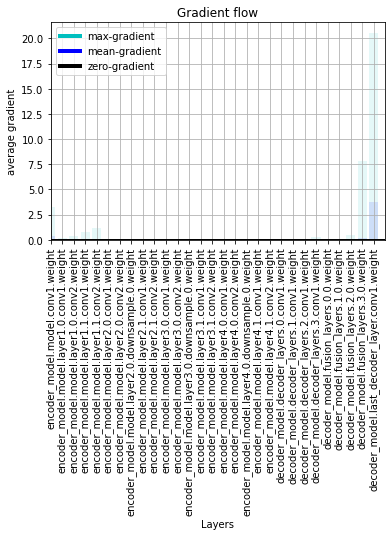

Iter: 10 | Train loss on last  10 : total - 256.5878021240234, content-42062.11484375, style-172.46357192993165


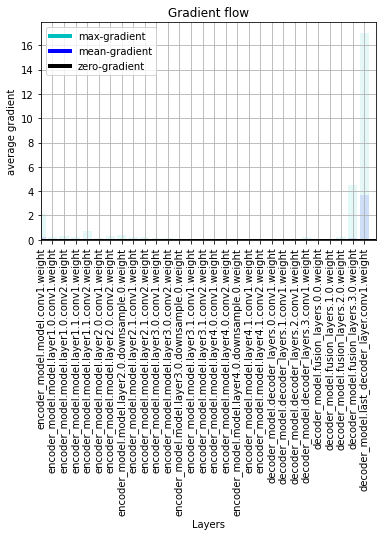

Iter: 20 | Train loss on last  10 : total - 222.53756103515624, content-36613.830078125, style-149.30989685058594


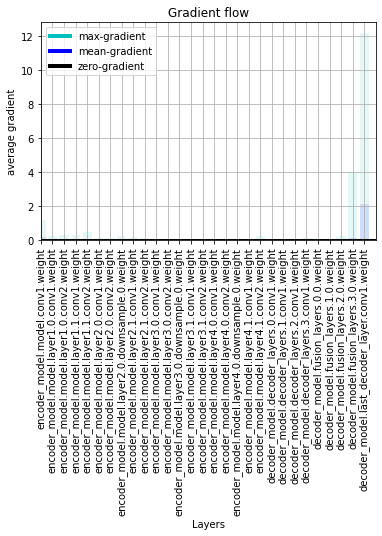

Iter: 30 | Train loss on last  10 : total - 220.05267791748048, content-34671.194140625, style-150.71028823852538


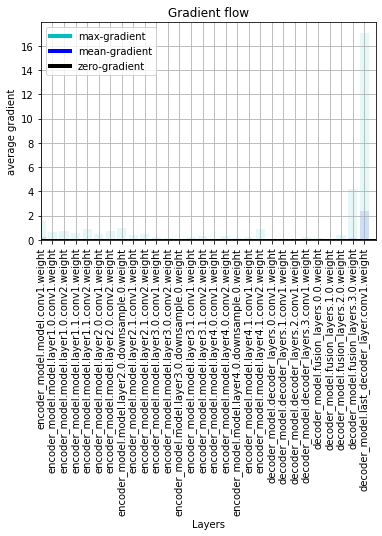

Iter: 40 | Train loss on last  10 : total - 190.0288345336914, content-31385.0404296875, style-127.25875091552734


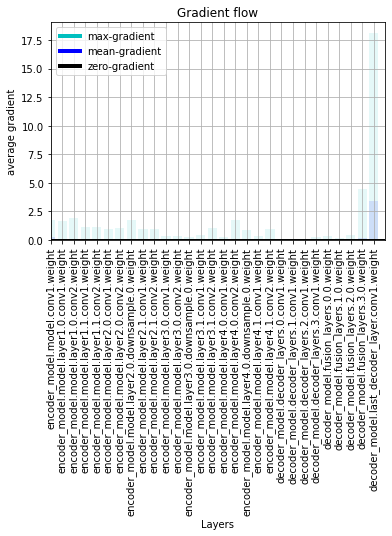

Iter: 50 | Train loss on last  10 : total - 176.39642181396485, content-29882.949609375, style-116.63051910400391


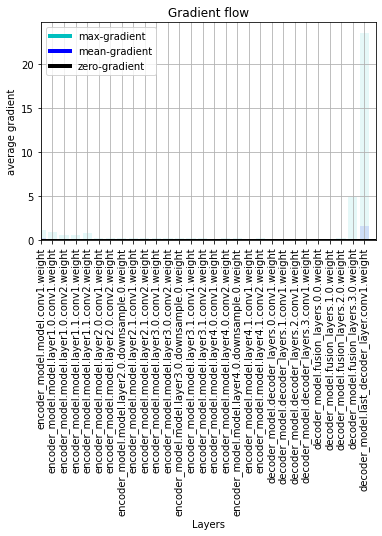

Iter: 60 | Train loss on last  10 : total - 160.47274475097657, content-27303.9099609375, style-105.86492385864258


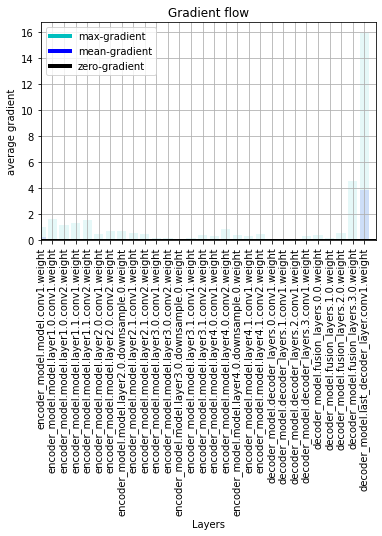

Iter: 70 | Train loss on last  10 : total - 165.78595123291015, content-28690.19296875, style-108.40556335449219


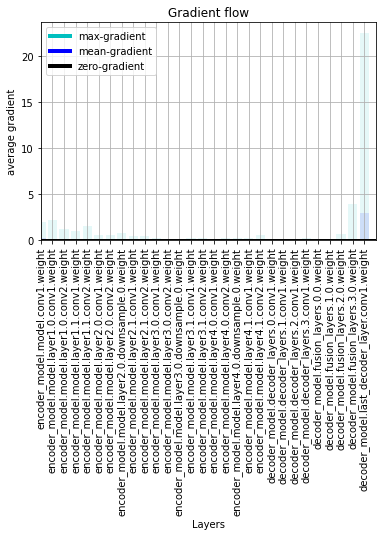

Iter: 80 | Train loss on last  10 : total - 164.41476287841797, content-29094.0046875, style-106.22675094604492


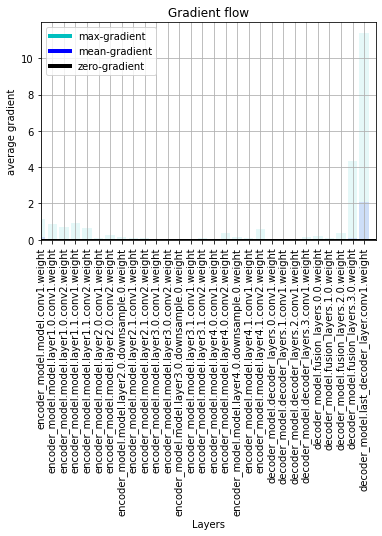

Iter: 90 | Train loss on last  10 : total - 152.5294387817383, content-27307.4166015625, style-97.91460189819335


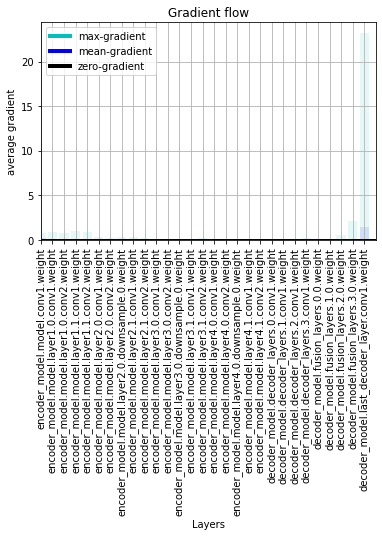

Iter: 100 | Train loss on last  10 : total - 140.92813568115236, content-25191.9298828125, style-90.54427490234374


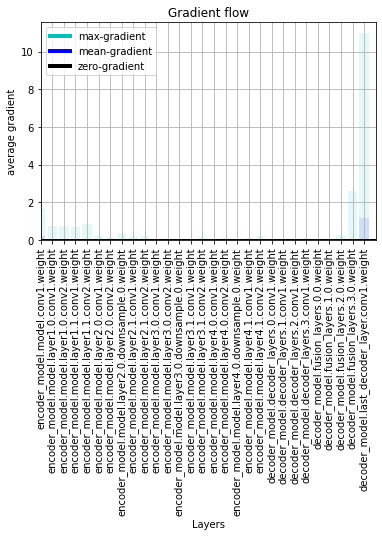

Iter: 110 | Train loss on last  10 : total - 173.57385177612304, content-30636.4728515625, style-112.30090293884277


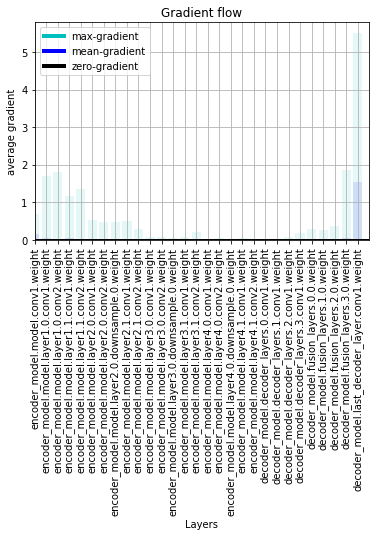

Iter: 120 | Train loss on last  10 : total - 167.14854736328124, content-26996.0470703125, style-113.15645141601563


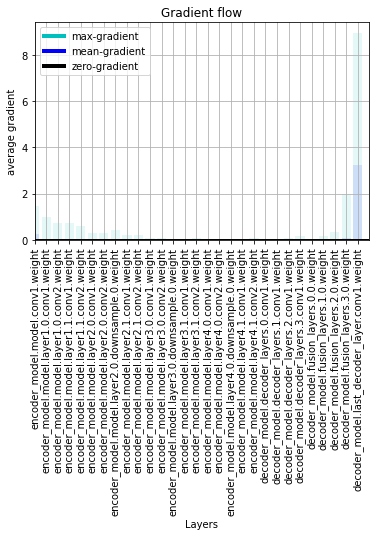

Iter: 130 | Train loss on last  10 : total - 146.54817657470704, content-25454.2560546875, style-95.63966369628906


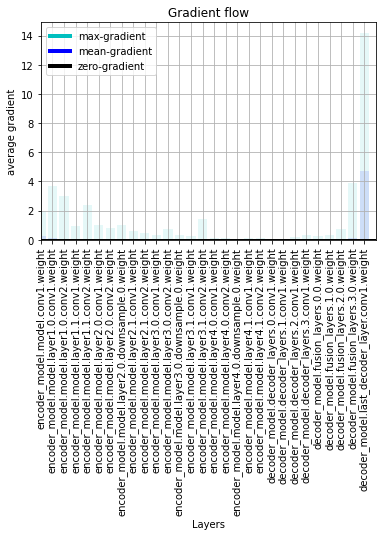

Iter: 140 | Train loss on last  10 : total - 153.1051223754883, content-26916.537109375, style-99.2720458984375


In [ ]:
main_model = train(main_model,
                  Adam,
                  dataset_train,
                  loss_model,
                  500,
                  batch_size=2,
                  lr=2e-4,
                  out_frequency=10,
                  alpha=2e-3)

In [ ]:
#main_model

In [ ]:
#list(main_model.named_parameters())

In [ ]:
#list(main_model.weights.named_parameters())

In [ ]:
#w = [torch.clone(w.data) for w in main_model.weights]
#w

In [ ]:
#main_model.weights[1].data = torch.zeros(1).to(DEVICE)
#main_model.weights[0].data

In [ ]:
main_model = main_model.eval()

In [ ]:
name = 'unet_model.pth'
torch.save(main_model.state_dict(), name)

In [ ]:
#resnet = nn.Sequential(od)
##adain = AdainBlock(LAYERS_NAME)
#decoder = DecoderBlock(CHANNELS_SIZES)


#main_model = STUNet(vgg, adain, decoder, LAYERS_NAME, CHANNELS_SIZES)

In [ ]:
#main_model.load_state_dict(torch.load(name))
#main_model = main_model.to(DEVICE)

In [ ]:
#main_model


In [ ]:
torch.cuda.empty_cache()
#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225])


contents, styles = dataset_test[0]
contents_t, styles_t = torch.unsqueeze(contents, 0).to(DEVICE), torch.unsqueeze(styles, 0).to(DEVICE)
main_model.weights = [3, 1, 1, 1, 1, 1]
out_img = main_model(normalize(contents_t), normalize(styles_t))[0]
print(out_img.shape, contents.shape)
pil_img = transforms.ToPILImage()(out_img.detach())



In [ ]:
from IPython.display import display # to display images
display(pil_img)
display(transforms.ToPILImage()(styles))
display(transforms.ToPILImage()(contents))

In [ ]:
t = torch.Tensor([[1, 2], [3, 4]])
print(torch.mean(t, (1), keepdims=True))

In [ ]:
p = nn.Parameter(torch.randn(1))

In [ ]:
p.data.item()

In [ ]:
a = torch.randn(2, 54, 224, 224)
a = a.view(2, 54, -1)

In [ ]:
a.shape

In [ ]:
from graphviz import Digraph
import torch
from torch.autograd import Variable, Function

def iter_graph(root, callback):
    queue = [root]
    seen = set()
    while queue:
        fn = queue.pop()
        if fn in seen:
            continue
        seen.add(fn)
        for next_fn, _ in fn.next_functions:
            if next_fn is not None:
                queue.append(next_fn)
        callback(fn)

def register_hooks(var):
    fn_dict = {}
    def hook_cb(fn):
        def register_grad(grad_input, grad_output):
            fn_dict[fn] = grad_input
        fn.register_hook(register_grad)
    iter_graph(var.grad_fn, hook_cb)

    def is_bad_grad(grad_output):
        if grad_output is None:
            return False
        return grad_output.isnan().any() or (grad_output.abs() >= 1e6).any()

    def make_dot():
        node_attr = dict(style='filled',
                        shape='box',
                        align='left',
                        fontsize='12',
                        ranksep='0.1',
                        height='0.2')
        dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))

        def size_to_str(size):
            return '('+(', ').join(map(str, size))+')'

        def build_graph(fn):
            if hasattr(fn, 'variable'):  # if GradAccumulator
                u = fn.variable
                node_name = 'Variable\n ' + size_to_str(u.size())
                dot.node(str(id(u)), node_name, fillcolor='lightblue')
            else:
                assert fn in fn_dict, fn
                fillcolor = 'white'
                if any(is_bad_grad(gi) for gi in fn_dict[fn]):
                    fillcolor = 'red'
                dot.node(str(id(fn)), str(type(fn).__name__), fillcolor=fillcolor)
            for next_fn, _ in fn.next_functions:
                if next_fn is not None:
                    next_id = id(getattr(next_fn, 'variable', next_fn))
                    dot.edge(str(next_id), str(id(fn)))
        iter_graph(var.grad_fn, build_graph)

        return dot

    return make_dot

x = torch.randn(10, 10, requires_grad=True)
y = torch.randn(10, 10, requires_grad=True)

z = x / (y * 0)
z = z.sum() * 2
get_dot = register_hooks(z)
z.backward()
dot = get_dot()
#dot.save('tmp.dot') # to get .dot
#dot.render('tmp') # to get SVG
dot # in Jupyter, you can just render the variable



In [ ]:
a = torch.Tensor([[[1,2],
                  [3, 4]]])
a.shape

In [ ]:
a.mean(dim=(-1,-2), keepdims=True)

In [ ]:
#def fuse_two_nets(net1, net2, alpha):



In [ ]:

    #normalize = nn.Sequential(transforms.Normalize(mean=, , ],
    #                             std=[0.229, 0.224, 0.225]))

In [ ]:
example = torch.randn(2, 3, 256, 256)

In [ ]:
(example - mu ) / std